In [15]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import lon180cesm, lon180, salmask, latweights, makedz

In [16]:
datafolder = ''

In [17]:
experiment = 'E280' 
model = 'CCSM4-UoT'
folder = datafolder+'Raw_data/'+model+'/'

In [18]:
if experiment == 'E280':
    ds = xr.open_dataset(folder+experiment+'/E280.nc')
    dsV = xr.open_dataset(folder+experiment+'/E280.nc')
    dsS = xr.open_dataset(folder+experiment+'/E280.nc')
else:
    ds = xr.open_dataset(folder+experiment+'/Eoi400.nc')
    dsV = xr.open_dataset(folder+experiment+'/Eoi400.nc')
    dsS = xr.open_dataset(folder+experiment+'/Eoi400.nc')

dsS = dsS.drop(['ULAT','ULONG','lat_aux_grid','moc_z'])
dsV = dsV.drop(['TLAT','TLONG','lat_aux_grid','moc_z'])

## Separating overturning and gyre FW Atlantic

In [19]:
salt = dsS.SALT
region=dsS.REGION_MASK

regridder = xe.Regridder(dsV, dsS, 'bilinear', periodic = True, ignore_degenerate=True)
vo = dsV.VVEL.fillna(0)
vvel = regridder(vo)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


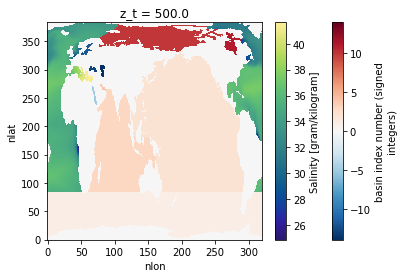

In [20]:
#Visualize region file
#region.where(region==10).plot(cmap='jet')
if experiment == 'E280':
    region.plot()
    dsS.SALT[0,:,:].where(region>5).where(region<10).plot(cmap='cmo.haline')

#Eoi400: 4 = Atlantic, 6 - 8 rest  
if experiment == 'Eoi400':
    region_excl = region.where(region==5).fillna(0)
    region = region-region_excl
    region.plot()
    dsT.SALT[0,:,:].where(region>3).where(region<9).plot(cmap='cmo.haline')

In [21]:
#Define reference salinity S0 as average Atlantic Ocean salinity
folder2 = datafolder+'Processed/'
ds = xr.open_dataset(folder2+model+'/'+experiment+'/so_1x1_100yr.nc')
ds = lon180(ds)

S0 = ds.so.where(salmask()>-1).weighted(makedz(ds)).mean(dim='z').weighted(latweights()).mean()

In [22]:
if experiment == 'E280':
    SALT = salt.where(region>5).where(region<10)  #  [g/kg]
    VVEL = vvel.where(region>5).where(region<10)
elif experiment == 'Eoi400':
    SALT = salt.where(region>3).where(region<9)  #  [g/kg]
    VVEL = vvel.where(region>3).where(region<9)
VVEL = VVEL*SALT/SALT #cm/s

In [23]:
def zonal_means(x, dx):
    xint = (x*dx).sum('nlon')  # [x-unit * cm]
    zm = xint/dx.sum('nlon')   # [x-unit]
    return zm

DXT = dsS.DXT
dz = dsS.dz

#Zonal mean salinity and velocity
VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

#Convert zonal means to 3D arrays
SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

# azonal components
SALT_prime = (SALT - SALT_zm_3D)  # azonal salt component (x,y,z) []
VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]

#Integrate to obtain Fov, Faz and Ftotal
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12 #[kg/g][cm/s][g/kg][cm^2]=cm^3/s--> Sv
Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['nlon','z_t']))/1e12 

Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12

In [24]:
# auxiliary latitudes for FW components
if experiment == 'E280':
    lats = dsS.TLAT.where(region>5).where(region<10).mean('nlon')
elif experiment == 'Eoi400':
    lats = dsS.TLAT.where(region>3).where(region<9).mean('nlon')

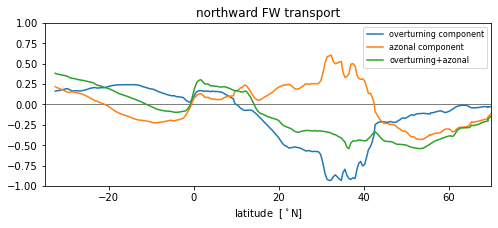

In [25]:
plt.figure(figsize=(8,3))
plt.axhline(0,c='k',lw=.5)
plt.plot(lats, Fov, label='overturning component')

plt.plot(lats, Faz, label='azonal component')
plt.plot(lats, Ftotal, label='overturning+azonal')
plt.title('northward FW transport')
plt.xlim([-35,70])
plt.ylim([-1,1])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [15]:
dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[85:-1]), Faz=(["lat"], Faz[85:-1]), Ftot=(["lat"], Ftotal[85:-1])), coords = dict(lat = lats[85:-1].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'/Processed/'+model+'/'+experiment+'/decomFW_100yr.nc')

## FW Labrador Sea

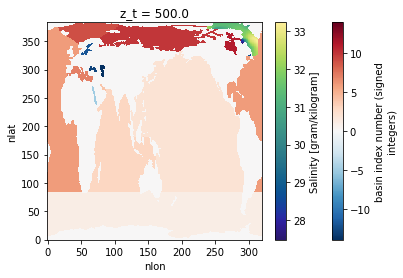

In [17]:
#Visualize mask
dsS = lon180cesm(dsS)

#region.plot()
#region.where(region==10).plot(cmap='jet')
if experiment == 'E280':
    region.plot()
    dsS.SALT[0,:,:].where(region>5).where(region<10).where(dsS.TLONG<-45).where(dsS.TLAT>=50).plot(cmap='cmo.haline') #Labrador Sea

#Eoi400: 4 = Atlantic, 6 - 8 rest  
if experiment == 'Eoi400':
    region_excl = region.where(region==5).fillna(0)
    region = region-region_excl
    region.plot()
    dsS.SALT[0,:,:].where(region>3).where(region<9).where(dsS.TLONG<-45).where(dsS.TLAT>=50).plot(cmap='cmo.haline')

In [19]:
if experiment == 'E280':
    SALT = salt.where(region>5).where(region<10).where(dsS.TLONG<-45).where(dsS.TLAT>=50) 
    VVEL = vvel.where(region>5).where(region<10).where(dsS.TLONG<-45).where(dsS.TLAT>=50)
elif experiment == 'Eoi400':
    SALT = salt.where(region>3).where(region<9).where(dsS.TLONG<-45).where(dsS.TLAT>=50)  
    VVEL = vvel.where(region>3).where(region<9).where(dsS.TLONG<-45).where(dsS.TLAT>=50)
    
VVEL = VVEL*SALT/SALT #cm/s

DXT = dsS.DXT
dz = dsS.dz

#zonal mean components
VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

# azonal components
SALT_prime = (SALT - SALT_zm_3D)  # azonal salt component (x,y,z) []
VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]
    
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['nlon','z_t']))/1e12

Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12

# auxiliary latitudes
if experiment == 'E280':
    lats = dsS.TLAT.where(region>5).where(region<10).where(dsS.TLONG<-45).where(dsS.TLAT>=50).mean('nlon')
elif experiment == 'Eoi400':
    lats = dsS.TLAT.where(region>3).where(region<9).where(dsS.TLONG<-45).where(dsS.TLAT>=50).mean('nlon')

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[-45:-10]), Faz=(["lat"], Faz[-45:-10]), Ftot=(["lat"], Ftotal[-45:-10])), coords = dict(lat = lats[-45:-10].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Lab_100yr.nc')

## FW Fram Strait

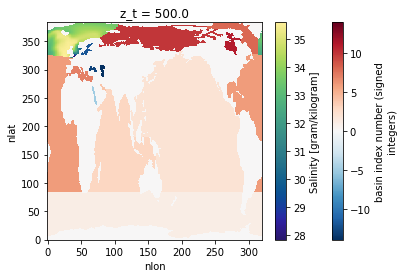

In [20]:
# Visualize region

if experiment == 'E280':
    region.plot()
    dsS.SALT[0,:,:].where(region>5).where(region<10).where(dsS.TLONG>=-45).where(dsS.TLAT>=50).plot(cmap='cmo.haline') #Labrador Sea

#Eoi400: 4 = Atlantic, 6 - 8 rest  
if experiment == 'Eoi400':
    region_excl = region.where(region==5).fillna(0)
    region = region-region_excl
    region.plot()
    dsS.SALT[0,:,:].where(region>3).where(region<9).where(dsS.TLONG>=-45).where(dsS.TLAT>=50).plot(cmap='cmo.haline')

In [21]:
if experiment == 'E280':
    SALT = salt.where(region>5).where(region<10).where(dsS.TLONG>=-45).where(dsS.TLAT>=50) 
    VVEL = vvel.where(region>5).where(region<10).where(dsS.TLONG>=-45).where(dsS.TLAT>=50)
elif experiment == 'Eoi400':
    SALT = salt.where(region>3).where(region<9).where(dsS.TLONG>=-45).where(dsS.TLAT>=50)  
    VVEL = vvel.where(region>3).where(region<9).where(dsS.TLONG>=-45).where(dsS.TLAT>=50)
    
VVEL = VVEL*SALT/SALT #cm/s

DXT = dsS.DXT
dz = dsS.dz

VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

# azonal components
SALT_prime = (SALT - SALT_zm_3D)  # azonal salt component (x,y,z) []
VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]

Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['nlon','z_t']))/1e12

Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12

# auxiliary latitudes
if experiment == 'E280':
    lats = dsS.TLAT.where(region>5).where(region<10).where(dsS.TLONG>=-45).where(dsS.TLAT>=50).mean('nlon')
elif experiment == 'Eoi400':
    lats = dsS.TLAT.where(region>3).where(region<9).where(dsS.TLONG>=-45).where(dsS.TLAT>=50).mean('nlon')

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[-45:-17]), Faz=(["lat"], Faz[-45:-17]), Ftot=(["lat"], Ftotal[-45:-17])), coords = dict(lat = lats[-45:-17].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Fram_100yr.nc')

## FW transport Bering Strait

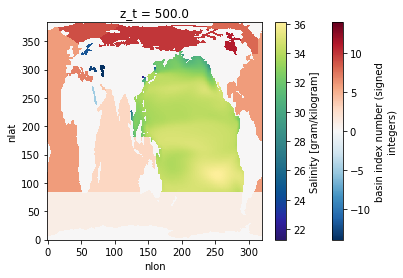

In [22]:
#Visualize region
if experiment == 'E280':
    region.plot()
    dsS.SALT[0,:,:].where(region==2).plot(cmap='cmo.haline') #Labrador Sea

In [24]:
if experiment =='E280':

    if experiment == 'E280':
        SALT = salt.where(region==2)  
        VVEL = vvel.where(region==2)
    elif experiment == 'Eoi400':
        SALT = salt.where(region>3).where(region<9)  
        VVEL = vvel.where(region>3).where(region<9)

    VVEL = VVEL*SALT/SALT #cm/s

    DXT = dsS.DXT
    dz = dsS.dz

    VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
    SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

    SALT_zm_3D = SALT/SALT
    SALT_zm_3D = SALT_zm_3D*SALT_zm

    VVEL_zm_3D = VVEL/VVEL
    VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

    # azonal components
    SALT_prime = (SALT - SALT_zm_3D)  # azonal salt component (x,y,z) []
    VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]
    
    Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12 # 1 Sv = 1e12 cm^3/s
    Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['nlon','z_t']))/1e12

    Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12

    # auxiliary latitudes for plotting
    if experiment == 'E280':
        lats = dsS.TLAT.where(region==2).mean('nlon')
    elif experiment == 'Eoi400':
        lats = dsS.TLAT.where(region>3).where(region<9).mean('nlon')

    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[85:-50]), Faz=(["lat"], Faz[85:-50]), Ftot=(["lat"], Ftotal[85:-50])), coords = dict(lat = lats[85:-50].values))
    xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_BS_100yr.nc')